In [337]:
import operator
import bokeh
import gensim
import nltk
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np
from nltk.collocations import BigramCollocationFinder

%matplotlib inline

## Setup

In [3]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()

In [345]:
def prepare_text(text, stop_words):
    tokenizer = nltk.tokenize.WordPunctTokenizer()
    stemmer = nltk.stem.PorterStemmer()
    
    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if len(t) > 2]
    tokens = [t for t in tokens if t not in stop_words]
    
    tokens = [t.lower() for t in tokens]
    tokens = [t for t in stems if not t.isdigit()]
    
    return stems

In [5]:
with open('stop_words_en_long.txt', 'r') as f:
    stop_words = f.read()
stop_words = stop_words.split('\n')

In [201]:
df_may = pd.read_csv('hansard_csv/may.csv')
df_hammond = pd.read_csv('hansard_csv/hammond.csv')
df_rudd = pd.read_csv('hansard_csv/rudd.csv')
df_johnson = pd.read_csv('hansard_csv/johnson.csv')
df_fallon = pd.read_csv('hansard_csv/fallon.csv')

df_corbyn = pd.read_csv('hansard_csv/corbyn.csv')
df_mcdonnell = pd.read_csv('hansard_csv/mcdonnell.csv')
df_abbott = pd.read_csv('hansard_csv/abbott.csv')
df_thornberry = pd.read_csv('hansard_csv/thornberry.csv')
df_griffith = pd.read_csv('hansard_csv/griffith.csv')


In [344]:
# fix a scraping mistake
df_may['mp'] = 'Theresa May'

In [203]:
df_all = pd.concat([df_may, df_hammond, df_rudd, df_johnson, df_fallon, df_corbyn, df_mcdonnell, df_abbott, df_thornberry, df_griffith])

In [204]:
df_all['tokens'] = df_all['text'].map(lambda x: prepare_text(str(x), stop_words))

In [328]:
mps = ['Theresa May', 'Philip Hammond', 'Amber Rudd', 'Boris Johnson', 'Michael Fallon', 
       'Jeremy Corbyn', 'John McDonnell', 'Diane Abbott', 'Emily Thornberry', 'Nia Griffith']
con = ['Theresa May', 'Philip Hammond', 'Amber Rudd', 'Boris Johnson', 'Michael Fallon']
lab = ['Jeremy Corbyn', 'John McDonnell', 'Diane Abbott', 'Emily Thornberry', 'Nia Griffith']

df_all['party'] = 0

for c in con:
    df_all['party'][df_all['mp'] == c] = 1
    
for l in lab:
    df_all['party'][df_all['mp'] == l] = 0

/Users/George/miniconda3/envs/nlp3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/nlp3/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Tf-Idf

In [11]:
def lsi_to_vecs(corpus_lsi):
    lsi_vecs = []

    for c in corpus_lsi:
        vec = [x[1] for x in c]
        lsi_vecs.append(vec)

    return np.array(lsi_vecs)

In [318]:
def tfidf_transform(texts, dictionary=None, tfidf_model=None):
    if not dictionary:
        dictionary = gensim.corpora.Dictionary(texts)
        dictionary.filter_extremes(no_below=5, no_above=0.2)
    corpus = [dictionary.doc2bow(text) for text in texts]
    if not tfidf_model:
        tfidf_model = gensim.models.TfidfModel(corpus)
    corpus_tfidf = tfidf_model[corpus]
    return corpus_tfidf, dictionary, tfidf_model

def lsi_transform(corpus_tfidf, dictionary, lsi_model=None, dimensions=2, topn=25):
    if not lsi_model:
        lsi_model = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=dimensions)
    corpus_lsi = lsi_model[corpus_tfidf]
    lsi_vecs = lsi_to_vecs(corpus_lsi)
    lsi_vecs = lsi_vecs
    return lsi_vecs, corpus_lsi, lsi_model

In [319]:
corpus_tfidf, dictionary, tfidf_model = tfidf_transform(df_all['tokens'])


In [320]:
lsi_vecs, corpus_lsi, lsi_model = lsi_transform(corpus_tfidf, 
                                                dictionary)

In [322]:
topic_x = []
topic_y = []
for l in lsi_vecs:
    try:
        topic_x.append(l[0])
        topic_y.append(l[1])
    except:
        topic_x.append(10)
        topic_y.append(10)

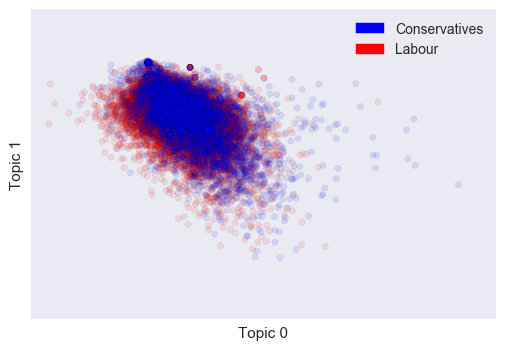

In [351]:
plt.scatter(topic_x, topic_y, c=df_all['party'], alpha=0.1)
plt.xlim(-0.00005,0.00015)
plt.ylim(-0.5,0.1)
plt.xlabel('Topic 0')
plt.ylabel('Topic 1')
red_patch = mpatches.Patch(color='red', label='Labour')
blue_patch = mpatches.Patch(color='blue', label='Conservatives')
plt.legend(handles=[blue_patch, red_patch])
plt.xticks([])
plt.yticks([])
plt.savefig('lsi-2d-con-lab.png')

## Word2Vec

In [251]:
w2v_cons = gensim.models.Word2Vec(df_all['tokens'][df_all['party']==0], min_count=1, size=2)

In [252]:
w2v_labs = gensim.models.Word2Vec(df_all['tokens'][df_all['party']==1], min_count=1, size=2)

In [276]:
topics = ['economy', 'education', 'defence', 'health', 'transport', 'environment']

def party_word_vectors(models, topics):
    x = []
    y = []
    parties = []
    for i, m in enumerate(models):
        for t in topics:
            parties.append(i)
            x.append(m[t][0])
            y.append(m[t][1])
    return x, y, parties

In [277]:
x, y, parties = party_word_vectors([w2v_labs, w2v_cons], topics)
d = {'x':x, 'y':y}
df = pd.DataFrame(d)

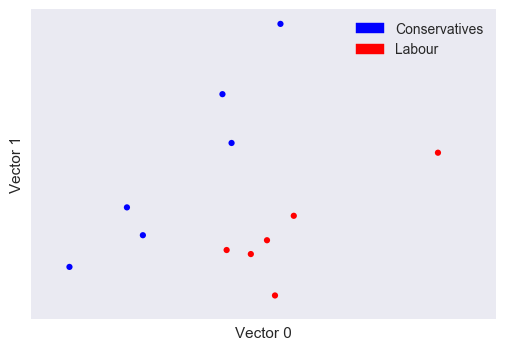

In [352]:
plt.scatter(x, y, c=parties, linewidth=0)
plt.set_cmap('bwr')
red_patch = mpatches.Patch(color='red', label='Labour')
blue_patch = mpatches.Patch(color='blue', label='Conservatives')
plt.legend(handles=[blue_patch, red_patch])
plt.xlabel('Vector 0')
plt.ylabel('Vector 1')
plt.xticks([])
plt.yticks([])

plt.savefig('word2vec-2d-con-lab.png')